## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

#from imblearn.under_sampling import RandomUnderSampler ne fonctionne pas
#from imblearn.over_sampling import RandomOverSampler ne fonctionne pas

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LogisticRegression


#Interpretability 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from alibi.explainers import ALE, plot_ale


import warnings
warnings.filterwarnings('ignore')

C:\Users\mathi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [3]:
def data_prep_brest_cancer(df, features_name):
    # Calcul de la matrice de corrélation
    m_corr = df[features_name].corr(method="spearman")
    
    # Récupération de la partie supérieure de la matrice de corrélation
    upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape), k=1).astype(bool)) 
    
    # Suppression des colonnes avec une corrélation supérieure à 0.85
    drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    
    # Suppression des colonnes trop corrélées
    no_corr = df.drop(drop, axis=1)
    
    # Sélection des caractéristiques d'entraînement (tout sauf la dernière colonne qui est la cible)
    training_features = no_corr.columns[:-1]

    # Séparation des caractéristiques et de la cible
    X = no_corr[training_features]
    y = no_corr['target']  # Assurez-vous que 'target' est la colonne de la cible
    
    # Séparation en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
    
    # Normalisation des données
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Retour des résultats
    return X_train_sc, X_test_sc, y_train, y_test, training_features, scaler

In [4]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

Ici, nos souhaitons déterminer s'il s'agit d'un cancer, ainsi il faut inverser les modalités de Y pour que 1 soit maligne et 0 bénine

In [5]:
breast.target = 1- breast.target

#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)



In [6]:
X_train_sc, X_test_sc, y_train, y_test, training_features, scaler = data_prep_brest_cancer(df=breast, features_name=features_name)

In [7]:
svm_pipeline = SVC(random_state=77, C=0.5, kernel='poly',degree=2)

In [8]:
svm_pipeline.fit(X_train_sc, y_train)

SVC(C=0.5, degree=2, kernel='poly', random_state=77)

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [9]:
#Prédiction pour un individu
svm_pipeline.predict(X_test_sc[0].reshape(1,16))

array([0.])

#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

In [10]:
logistic = LogisticRegression( random_state=77)
logistic.fit(X_train_sc, y_train)

LogisticRegression(random_state=77)

In [11]:
#coefficients standardisés
coef = pd.DataFrame(np.abs(logistic.coef_[0]),index=training_features,columns=['abs(coef)'])
coef.sort_values(by='abs(coef)', ascending=False)

,abs(coef)
mean_radius,2.746734
radius_error,2.375767
worst_symmetry,1.364410
mean_texture,1.114400
worst_smoothness,1.093278
concave_points_error,1.028297
worst_fractal_dimension,0.858887
fractal_dimension_error,0.851973
mean_fractal_dimension,0.827682
symmetry_error,0.620869


Les variables les plus influentes dans la prédiction de la malignité des tumeurs sont principalement liées aux caractéristiques géométriques et de forme des cellules tumorales. Par exemple, le **mean_radius** (rayon moyen) et le **radius_error** (erreur du rayon) montrent une forte corrélation avec la malignité, ce qui suggère que les tumeurs plus grandes et avec une plus grande variabilité dans leur taille sont plus susceptibles d'être malignes. De même, des mesures comme **worst_symmetry** et **worst_smoothness** indiquent que des tumeurs asymétriques et irrégulières sont souvent malignes. D'autres facteurs, comme la **mean_texture** (texture moyenne) et la **concave_points_error** (erreur des points concaves), reflètent des irrégularités dans la surface de la tumeur, un autre signe distinctif des tumeurs malignes. Ces résultats montrent que la forme et la complexité des tumeurs sont des indicateurs cruciaux dans la prédiction du cancer.

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

##### Partial depence plot

In [12]:
df_interpret = pd.DataFrame(X_test_sc, columns = training_features)

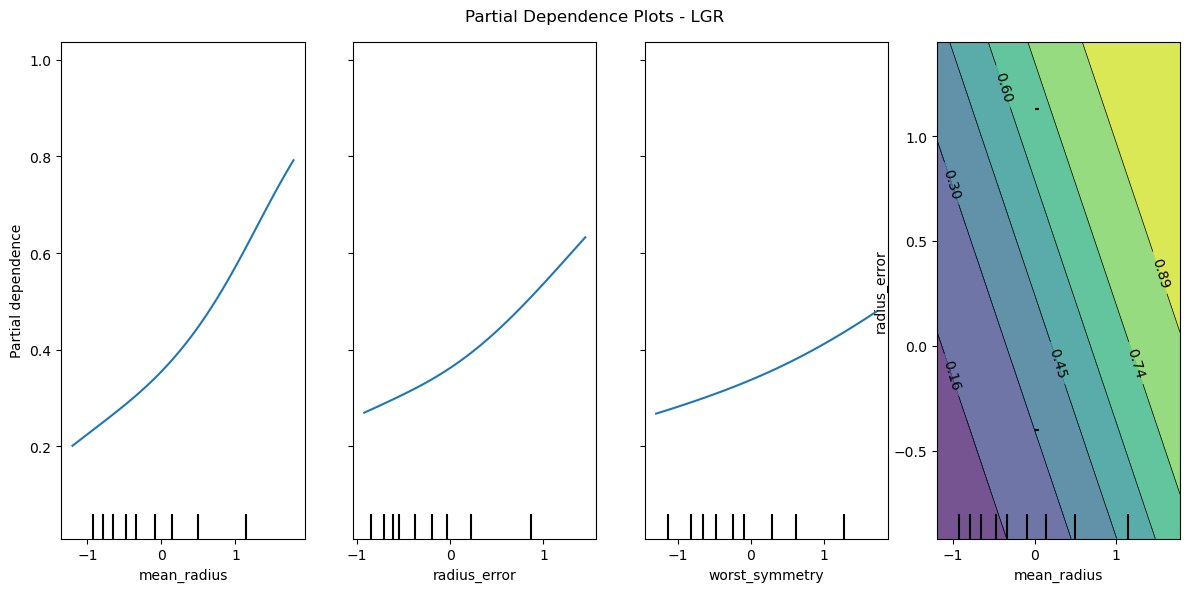

In [13]:
features = ["mean_radius","radius_error","worst_symmetry" ,('mean_radius','radius_error')]  #Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(logistic, 
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, #Nombre de points estimés pour le tracer de la courbe
                                         n_cols=4
                                         )
plt.suptitle("Partial Dependence Plots - LGR")
plt.tight_layout()
plt.show()

Les résultats confirment les effets que nous avons observés dans l’interprétation du modèle de régression logistique. En effet, lorsque la variable **mean_radius** s’écarte de sa valeur moyenne de manière positive, cela semble augmenter significativement la probabilité de présence d’une tumeur maligne. Cette relation suggère que plus le rayon moyen de la tumeur est important, plus le risque de malignité augmente, ce qui est cohérent avec les attentes cliniques, où des tumeurs plus grandes sont généralement associées à une plus grande probabilité d’être malignes. 

Ce phénomène souligne l’importance de **mean_radius** dans la prédiction du type de tumeur. Il pourrait être interprété comme un indicateur crucial pour différencier les tumeurs bénignes des malignes. Une valeur plus élevée de cette caractéristique semble effectivement augmenter la gravité de la condition, renforçant ainsi la pertinence de cette variable dans la classification des tumeurs.

##### Accumulated local effect

In [14]:
ale = ALE(logistic.predict, feature_names=training_features, target_names=["prob_cancer"])
ale2 = ale.explain(X_test_sc, min_bin_points=10)

array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='radius_error', ylabel='ALE'>]], dtype=object)

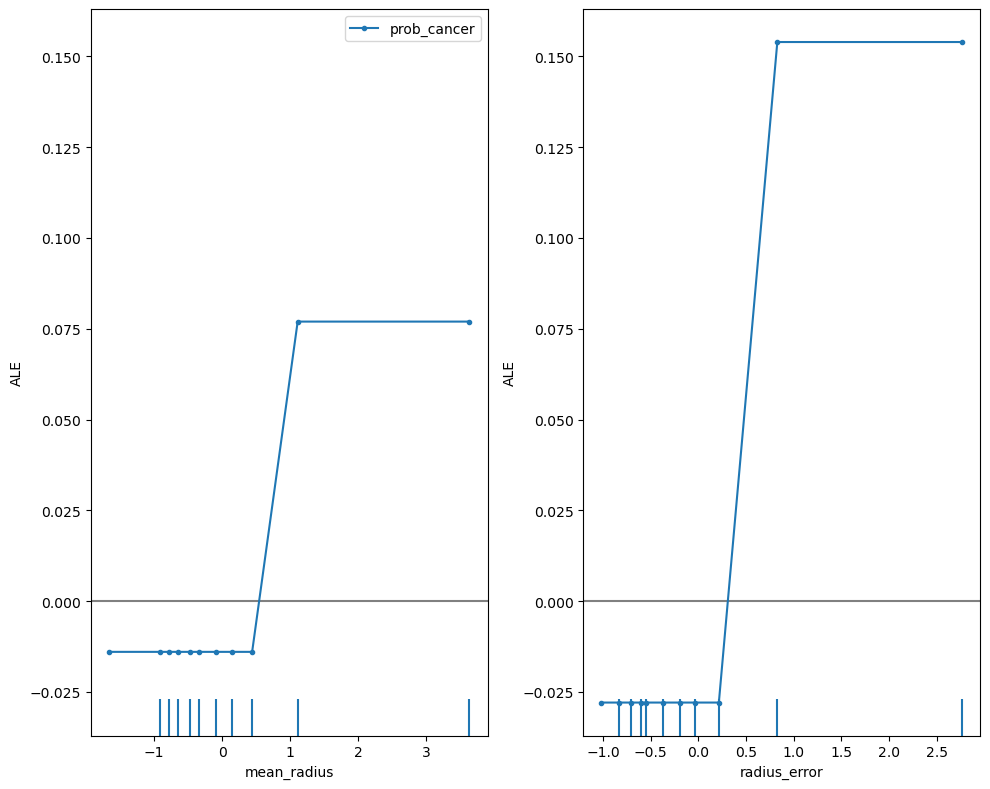

In [15]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(ale2, features=["mean_radius","radius_error"], ax= ax1, targets=[0])

Le calcul des **ALE** (Accumulated Local Effects) produit un résultat similaire en termes d'interprétation des relations entre les variables et la probabilité d'une tumeur maligne. En effet, l'analyse ALE permet de visualiser de manière plus détaillée l'impact local d'une variable sur la prédiction du modèle, tout en prenant en compte les interactions avec d'autres variables. Dans ce cas, l'effet observé pour **mean_radius** via l'analyse ALE confirme la tendance identifiée dans le modèle de régression logistique : un écart positif de cette variable par rapport à sa moyenne augmente la probabilité d’une tumeur maligne. 

##### H statistic

In [16]:
h = FriedmanHStatisticMethod()
h.fit(logistic, pd.DataFrame(X_test_sc, columns=training_features), batchsize=100)

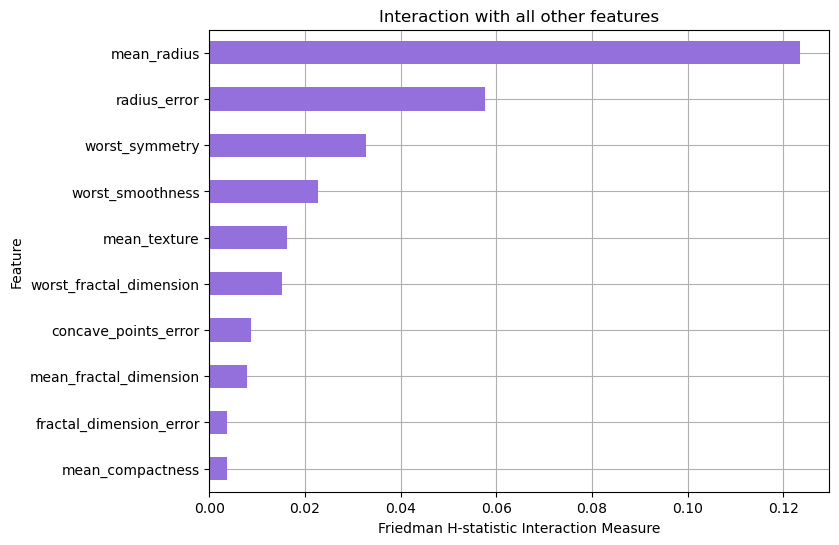

In [17]:
# Interaction One vs All
h.plot(vis_type="bar_chart_ova",top_k=10 )

L'analyse réalisée avec la méthode **FriedmanHStatisticMethod()** permet de mesurer l'importance des différentes variables dans le modèle de régression logistique pour prédire si une tumeur est bénigne ou maligne. Les résultats montrent que certaines variables, comme **mean_radius**, **radius_error**, et **worst_symmetry**, sont particulièrement importantes pour la prédiction.

Cela confirme les conclusions obtenues avec d'autres méthodes d'analyse, où ces variables étaient aussi identifiées comme influentes. Par exemple, lorsque **mean_radius** et **radius_error** augmentent, les chances de prédire une tumeur maligne augmentent également.

##### Permutation feature importance

In [18]:
resultat = permutation_importance(logistic, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring='accuracy'
                           )


In [19]:
pd.DataFrame(resultat.importances_mean, index=training_features, columns=['P-importance']).sort_values(by="P-importance", ascending=False)

,P-importance
mean_radius,0.095322
radius_error,0.050877
worst_symmetry,0.040936
worst_smoothness,0.030994
mean_texture,0.025731
mean_fractal_dimension,0.017544
worst_fractal_dimension,0.016959
concave_points_error,0.014035
symmetry_error,0.011696
fractal_dimension_error,0.011111


Les résultats d'importance des variables montrent que **mean_radius** est la variable la plus influente dans la prédiction, avec une importance de **0.095322**, suivie par **radius_error** et **worst_symmetry**, qui ont également une influence notable. Ces variables semblent capturer des informations cruciales pour la classification. D'autres variables comme **worst_smoothness** et **mean_texture** contribuent également, bien qu'à un degré moindre, ce qui suggère qu'elles apportent des informations supplémentaires mais moins déterminantes. En revanche, des variables telles que **smoothness_error** ont une importance nulle, indiquant qu'elles n'apportent aucune valeur ajoutée au modèle et pourraient être exclues pour simplifier la modélisation.

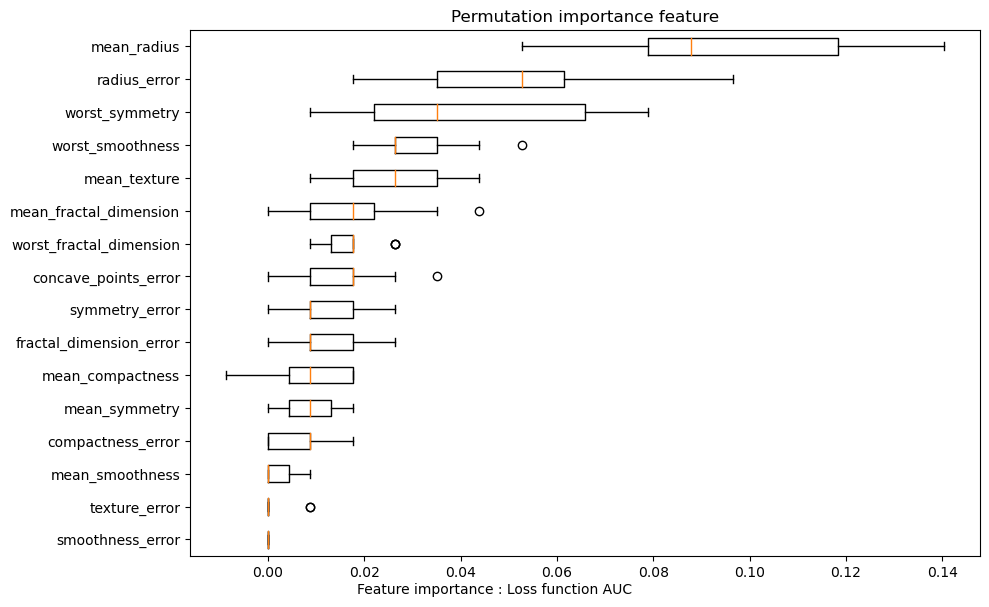

In [20]:
sortie = resultat.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    resultat.importances[sortie].T,
    vert=False,
    labels=training_features[sortie]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()

#### 6) Commenter et discuter des limites

L'interprétabilité devient plus compliquée lorsqu'on applique des techniques de prétraitement, comme la standardisation, car cela modifie la manière dont les variables influencent le modèle. La standardisation, qui ajuste les données pour qu'elles aient une moyenne de zéro et une variance de un, peut rendre plus difficile la compréhension des coefficients du modèle. Cependant, elle permet au modèle de mieux apprendre et évite les problèmes liés aux différences d'échelle entre les variables.

En parallèle, une approche "modèle agnostique" permet d'utiliser des méthodes d'interprétation indépendantes du modèle choisi, comme la régression linéaire. Ces méthodes fournissent une analyse similaire de l'importance des variables, même si le modèle utilisé est différent. Cela signifie qu'on peut comprendre le modèle de manière claire, tout en restant flexible avec la méthode choisie.

modèle agnostique = boite blanche

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales

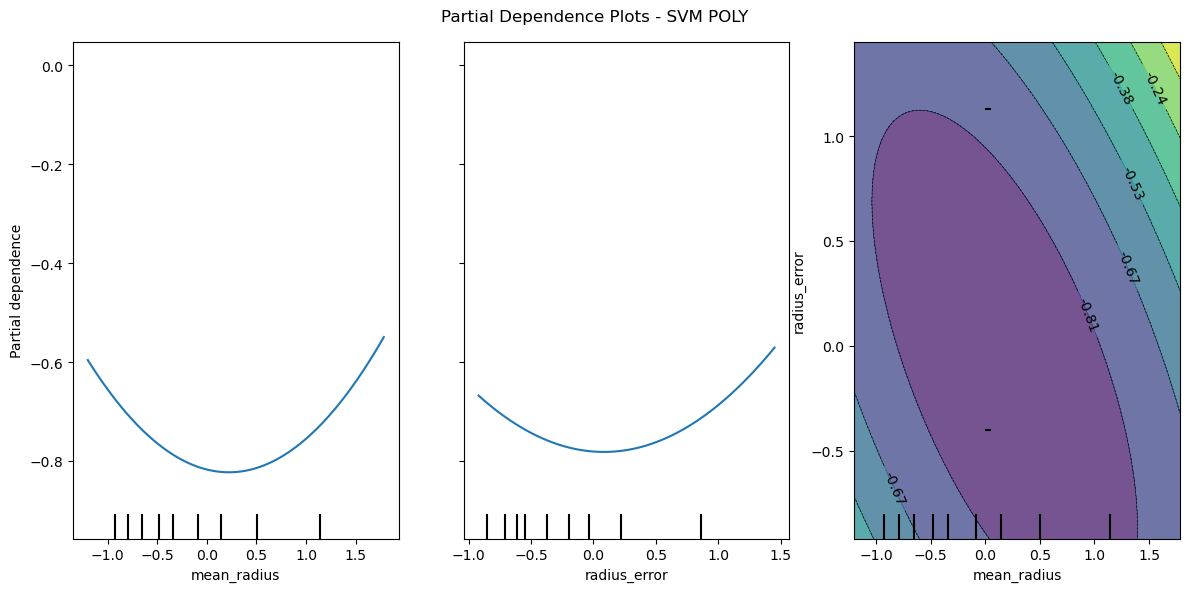

In [21]:
features = ["mean_radius","radius_error" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(
                                        svm_pipeline, 
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3
                                         )
plt.suptitle("Partial Dependence Plots - SVM POLY")
plt.tight_layout()
plt.show()

Les effets des variables sur le modèle sont moins marqués et plus nuancés par rapport à ceux observés dans le modèle linéaire. En effet, dans le cadre de ce modèle, les relations entre les variables explicatives et la variable cible ne suivent plus une **tendance linéaire**. Cela suggère que les interactions entre les différentes variables sont plus complexes et ne peuvent pas être capturées par une simple relation linéaire. Il est donc probable que d'autres formes de dépendances, non linéaires, influencent significativement la prédiction des résultats.

In [22]:
svm_ale = ALE(svm_pipeline.predict, feature_names=training_features, target_names=["probabilte_cancer"])
svm_exp = svm_ale.explain(X_test_sc, min_bin_points=10)

array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='mean_texture', ylabel='ALE'>]], dtype=object)

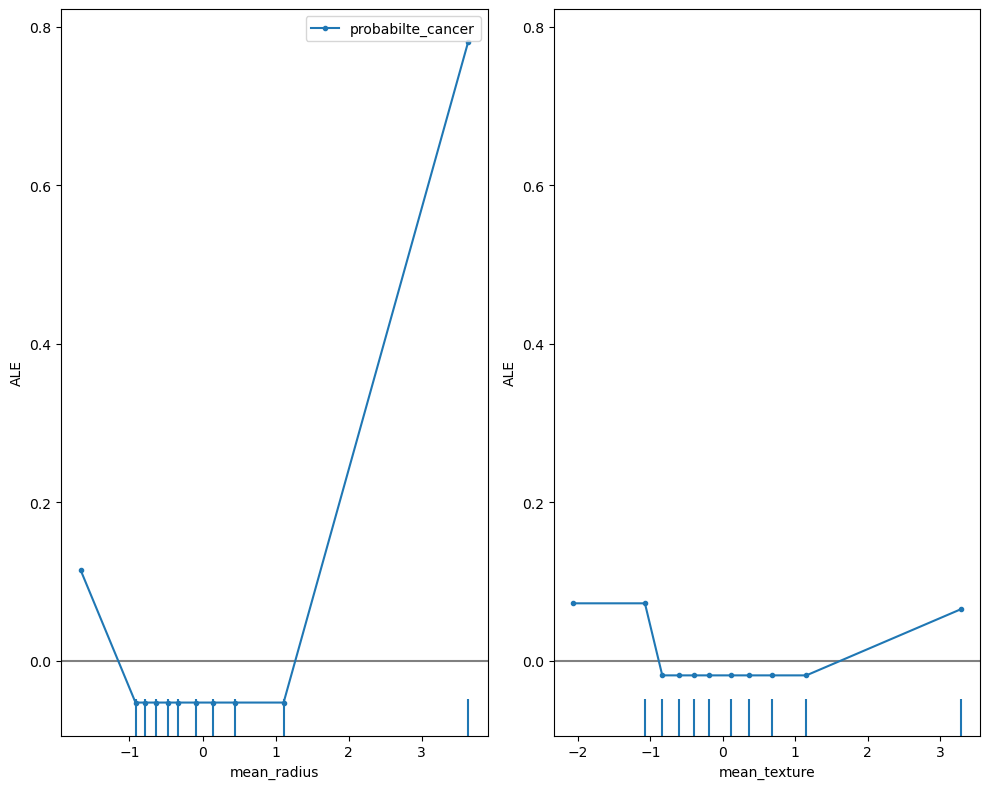

In [23]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(svm_exp, features=["mean_radius","mean_texture"], ax= ax1, targets=[0])

In [24]:
h = FriedmanHStatisticMethod()
h.fit(svm_pipeline, pd.DataFrame(X_test_sc, columns=training_features), batchsize=20)

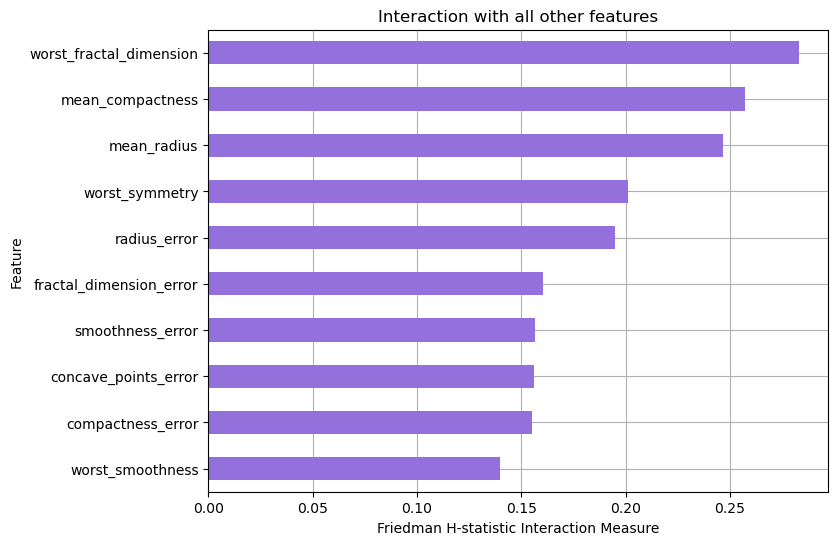

In [25]:
# Interaction One vs All
h.plot(vis_type="bar_chart_ova",top_k=10 )

Le graphique de type **bar_chart_ova** est utilisé pour visualiser l'importance des variables dans un modèle de classification multiclasse en appliquant la méthode **One-vs-All (OVA)**. Cette approche permet d'analyser l'impact de chaque variable pour différencier une classe spécifique de toutes les autres. 

Les résultats montrent que les variables, comme **worst_fractal_dimension**, **mean_compactness**, et **mean_radius**, sont particulièrement importantes pour la prédiction.

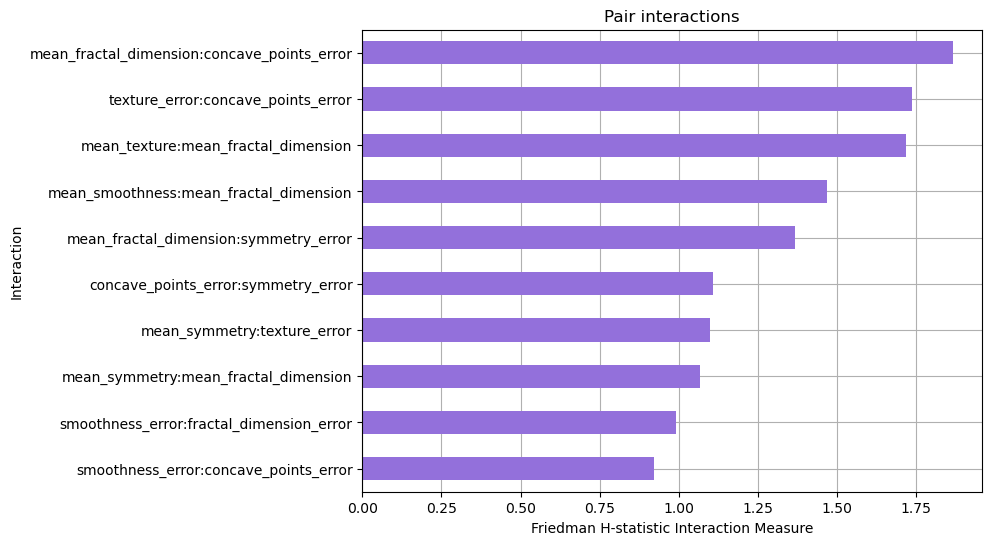

In [26]:
h.plot(vis_type="bar_chart",top_k=10 )

Le graphique **"bar_chart"** présente l'importance générale des variables dans le modèle de **manière globale**, sans se concentrer sur des classes spécifiques. Il montre comment chaque variable influence la prédiction du modèle dans son ensemble, ce qui permet d'identifier les variables les plus déterminantes pour la classification globale.

Ici les variables les plus contributives sont les suivantes : **mean_fractal_dimension:concave_points_error**, **texture_error:concave_points_error** et **mean_texture:concave_points_error**. Cela met en évidence des interactions clés où l'erreur associée à la concavité des points de la tumeur joue un rôle crucial dans la classification, en modifiant de manière significative l'influence des autres caractéristiques sur la prédiction."

In [27]:
resultat = permutation_importance(svm_pipeline, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring="accuracy"
                           )


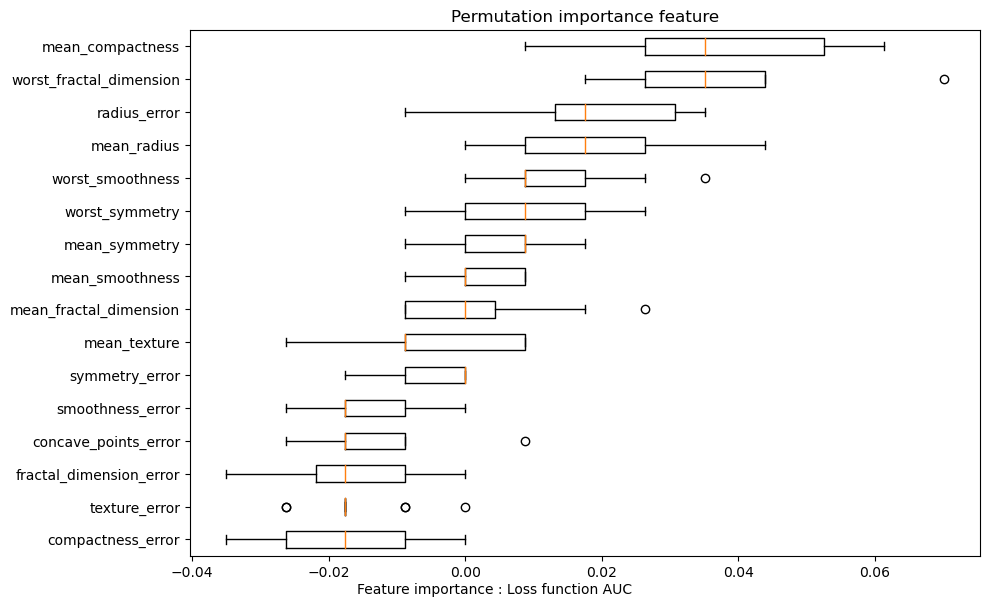

In [28]:
sortie = resultat.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    resultat.importances[sortie].T,
    vert=False,
    labels=training_features[sortie]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()

La variable **mean_compactness** joue un rôle important dans le modèle, et son absence a un impact notable sur la performance du modèle. En effet, en retirant cette variable, nous observons une diminution moyenne de **7%** de la valeur de l'AUC. Cela signifie que cette variable contribue de manière significative à la capacité du modèle à distinguer entre les classes, en améliorant sa précision dans la classification des tumeurs malignes et bénignes. L'impact de cette variable démontre son importance pour la qualité des prédictions du modèle, et son exclusion entraîne une perte d'information essentielle, ce qui se traduit par une réduction de la performance globale.